In [24]:
import keras
from keras import optimizers
from keras import losses
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, Embedding, LSTM
from keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard
from keras import regularizers

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow 
import sys
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tensorflow.__version__)



Python:  3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]
pandas:  0.24.2
numpy:  1.16.4
seaborn:  0.9.0
matplotlib:  3.1.0
sklearn:  0.21.2
Keras:  2.2.4
Tensorflow:  1.13.1


In [2]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)

        plt.figure(figsize=(10, 8))
        colors=[ "orange","green"]
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()


    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error': error,
                                 'true': y}).groupby('true')

        figure, axes = plt.subplots(figsize=(12, 8))

        for name, group in groupsDF:
            axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',
                    color='r' if name == 1 else 'g', label="Anomaly" if name == 1 else "Normal")

        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
        axes.legend()
        
        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

    def draw_error(self, error, threshold):
            plt.plot(error, marker='o', ms=3.5, linestyle='',
                     label='Point')

            plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors="b", zorder=100, label='Threshold')
            plt.legend()
            plt.title("Reconstruction error")
            plt.ylabel("Error")
            plt.xlabel("Data")
            plt.show()


In [3]:
filePath = './data/creditcardanomalydetection.csv'
df = pd.read_csv(filepath_or_buffer=filePath, header=0, sep=',')
print(df.shape[0])
df.head()


284807


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [13]:
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df0 = df.query('Class == 0').sample(20000)
df1 = df.query('Class == 1').sample(400)
df = pd.concat([df0, df1])

In [14]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(labels=['Time', 'Class'], axis = 1) , 
                                                    df['Class'], test_size=0.2, random_state=42)
print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')


(16320, 29) train samples
(4080, 29) test samples


In [15]:
#simple autoencoder
logfilename = "simpleautoencoder"

encoding_dim = 12
input_dim = x_train.shape[1]

inputArray = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(inputArray)

decoded = Dense(input_dim, activation='softmax')(encoded)

autoencoder = Model(inputArray, decoded)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 29)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 12)                360       
_________________________________________________________________
dense_14 (Dense)             (None, 29)                377       
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________


In [7]:
#sparse autoencoder
logfilename = "sparseautoencoder"

encoding_dim = 12
input_dim = x_train.shape[1]

inputArray = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu',
               activity_regularizer=regularizers.l1(10e-5))(inputArray)

decoded = Dense(input_dim, activation='softmax')(encoded)

autoencoder = Model(inputArray, decoded)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 29)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)                360       
_________________________________________________________________
dense_4 (Dense)              (None, 29)                377       
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________


In [8]:
#deep autoencoder
logfilename = "deepautoencoder"

encoding_dim = 16
input_dim = x_train.shape[1]

inputArray = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(inputArray)
encoded = Dense(8, activation='relu')(encoded)
encoded = Dense(4, activation='relu')(encoded)

decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(encoding_dim, activation='relu')(decoded)
decoded = Dense(input_dim, activation='softmax')(decoded)

autoencoder = Model(inputArray, decoded)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 29)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                480       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_9 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_10 (Dense)             (None, 29)                493       
Total para

In [16]:
autoencoder.compile(optimizer=RMSprop(), 
                    loss='mean_squared_error',
                    metrics=['mae', 'accuracy'])

In [17]:
batch_size = 32
epochs = 20

history = autoencoder.fit(x_train, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    validation_data=(x_test, x_test),
                    callbacks=[TensorBoard(log_dir='../logs/{0}'.format(logfilename))])


Instructions for updating:
Use tf.cast instead.
Train on 16320 samples, validate on 4080 samples
Epoch 1/20
16320/16320 [==============================] - 2s 139us/step - loss: 1.5386 - mean_absolute_error: 0.6801 - acc: 0.3179 - val_loss: 1.6385 - val_mean_absolute_error: 0.6842 - val_acc: 0.4588
Epoch 2/20
16320/16320 [==============================] - 2s 105us/step - loss: 1.4830 - mean_absolute_error: 0.6608 - acc: 0.5352 - val_loss: 1.6156 - val_mean_absolute_error: 0.6764 - val_acc: 0.5725
Epoch 3/20
16320/16320 [==============================] - 2s 106us/step - loss: 1.4720 - mean_absolute_error: 0.6576 - acc: 0.6147 - val_loss: 1.6091 - val_mean_absolute_error: 0.6755 - val_acc: 0.6480
Epoch 4/20
16320/16320 [==============================] - 2s 107us/step - loss: 1.4678 - mean_absolute_error: 0.6570 - acc: 0.6722 - val_loss: 1.6069 - val_mean_absolute_error: 0.6750 - val_acc: 0.6848
Epoch 5/20
16320/16320 [==============================] - 2s 105us/step - loss: 1.4662 - mean_a

In [18]:
score = autoencoder.evaluate(x_test, x_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

4080/4080 [==============================] - 0s 44us/step
Test loss: 1.60229444176543
Test accuracy: 0.6741862722471649


In [48]:
threshold=15.00
y_pred = autoencoder.predict(x_test)
y_dist = np.linalg.norm(x_test - y_pred, axis=-1)
z = zip(y_dist >= threshold, y_dist)
y_label=[]
error = []
for idx, (is_anomaly, y_dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(y_dist)



In [43]:
print(classification_report(y_test,y_label))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3987
           1       0.02      1.00      0.04        93

    accuracy                           0.02      4080
   macro avg       0.01      0.50      0.02      4080
weighted avg       0.00      0.02      0.00      4080



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [45]:
print(classification_report(y_test,y_label))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86      3987
           1       0.08      0.97      0.15        93

    accuracy                           0.76      4080
   macro avg       0.54      0.86      0.51      4080
weighted avg       0.98      0.76      0.84      4080



In [47]:
print(classification_report(y_test,y_label))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      3987
           1       0.41      0.86      0.56        93

    accuracy                           0.97      4080
   macro avg       0.71      0.92      0.77      4080
weighted avg       0.98      0.97      0.97      4080



In [49]:
print(classification_report(y_test,y_label))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3987
           1       0.57      0.66      0.61        93

    accuracy                           0.98      4080
   macro avg       0.78      0.82      0.80      4080
weighted avg       0.98      0.98      0.98      4080



In [40]:
roc_auc_score(y_test, y_label)

0.8778166136718529

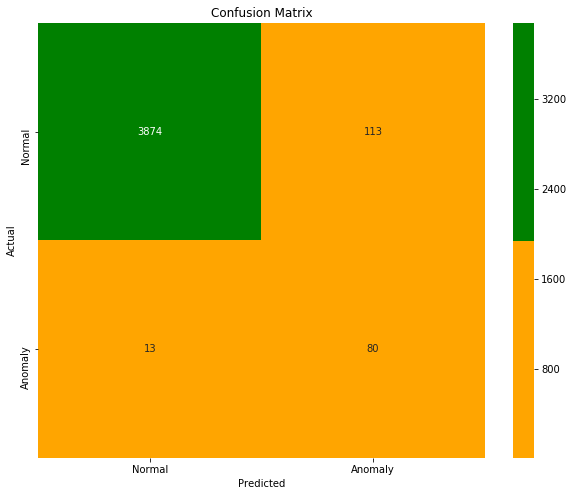

In [21]:
viz = Visualization()

viz.draw_confusion_matrix(y_test, y_label)

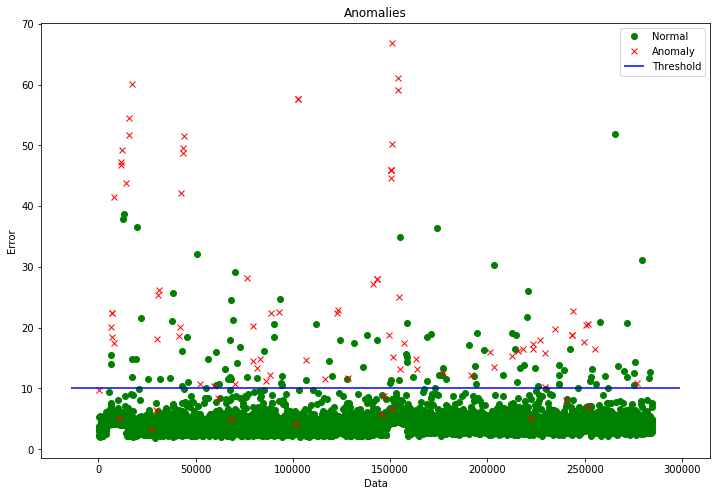

In [22]:
viz.draw_anomaly(y_test, error, threshold)